In [20]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

In [21]:
df = pd.read_parquet('../data/tom/exploretom/train.parquet')
dft = pd.read_parquet('../data/tom/exploretom/test.parquet')

In [22]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [23]:
len(dft)

2662

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10647 entries, 0 to 10646
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   story_structure                          10647 non-null  object 
 1   infilled_story                           10647 non-null  object 
 2   question                                 10647 non-null  object 
 3   expected_answer                          10647 non-null  object 
 4   qprop=params                             10647 non-null  object 
 5   qprop=nth_order                          10647 non-null  int64  
 6   qprop=non_unique_mental_state            10647 non-null  bool   
 7   sprop=is_false_belief_story_1st          10647 non-null  bool   
 8   sprop=is_false_belief_story_1st_and_2nd  10647 non-null  bool   
 9   sprop=story_accuracy_1st_raw             10647 non-null  float64
 10  sprop=story_accuracy_1st_infilled        10647

In [25]:
df.groupby(['qprop=non_unique_mental_state','qprop=nth_order',"param=num_people"]).prompt.count()

qprop=non_unique_mental_state  qprop=nth_order  param=num_people
False                           1               2                    675
                                                3                    340
                                                4                    287
                                2               2                   1003
                                                3                   1352
                                                4                   1756
True                           -1               2                    230
                                                3                    250
                                                4                    189
                                1               2                     52
                                                3                    550
                                                4                    720
                                2               2          

<Axes: xlabel='sprop=story_accuracy_1st_infilled', ylabel='Count'>

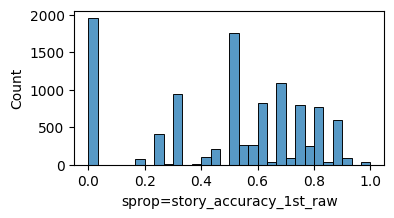

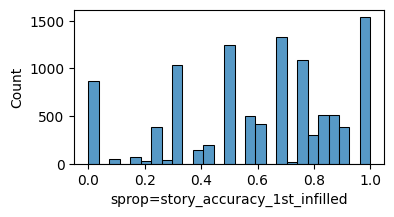

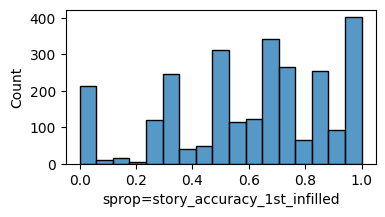

In [26]:
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=df['sprop=story_accuracy_1st_raw'], ax=ax)

_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=df['sprop=story_accuracy_1st_infilled'], ax=ax)

_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=dft['sprop=story_accuracy_1st_infilled'], ax=ax)

In [27]:
df_train = pd.concat([df, df], ignore_index=True)
df_train['story'] = np.concatenate([df.infilled_story.values, df.story_structure.values])
df_train['story_type']=['infilled_story']*len(df)+ ['story_structure']*len(df)
df_train = df_train.sample(frac=1, random_state=42)
df_train = df_train.loc[df_train['sprop=story_accuracy_1st_raw']<0.8]
df_train.index = range(len(df_train))
df_train = df_train.drop(columns=['infilled_story', 'story_structure'])
df_train = df_train.rename(columns={'expected_answer':'answer'})

df_test = pd.concat([dft, dft], ignore_index=True)
df_test['story'] = np.concatenate([dft.infilled_story.values, dft.story_structure.values])
df_test['story_type']=['infilled_story']*len(dft)+ ['story_structure']*len(dft)
df_test = df_test.drop(columns=['infilled_story', 'story_structure'])
df_test.index = range(len(df_test))
df_test = df_test.rename(columns={'expected_answer':'answer'})
dft = dft.rename(columns={'expected_answer':'answer'})

In [28]:
0.5*len(df_train)/len(df)

0.854419085188316

In [29]:
dfi = df_train.groupby(['qprop=params','param=num_people']).data_source.count().reset_index()
dfi.head(2)

,qprop=params,param=num_people,data_source
0,"(None, 'bag of gourmet coffee beans', 'ground_...",2,2
1,"(None, 'bag of gourmet coffee beans', 'memory-...",2,2


In [30]:
dfi.data_source.min()

2

In [31]:
# 分层去取样
df_sample = df_train.groupby(['qprop=params','param=num_people']).apply(lambda x: x.sample(n=2, replace=False), include_groups=False).reset_index()
#else
#df_sample = df_train.copy()

In [32]:
df_sample.loc[df_sample.answer.isin(['yes', 'no'])].groupby(['answer']).story.count()

answer
no      491
yes    3363
Name: story, dtype: int64

In [33]:
df_sample.loc[df_sample.answer.isin(['yes', 'no'])].groupby(['qprop=non_unique_mental_state','answer']).story.count()

qprop=non_unique_mental_state  answer
False                          yes       2301
True                           no         491
                               yes       1062
Name: story, dtype: int64

In [34]:
len(df_sample)

14760

In [35]:
SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [36]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14760 entries, 0 to 14759
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   qprop=params                             14760 non-null  object 
 1   param=num_people                         14760 non-null  int64  
 2   level_2                                  14760 non-null  int64  
 3   question                                 14760 non-null  object 
 4   answer                                   14760 non-null  object 
 5   qprop=nth_order                          14760 non-null  int64  
 6   qprop=non_unique_mental_state            14760 non-null  bool   
 7   sprop=is_false_belief_story_1st          14760 non-null  bool   
 8   sprop=is_false_belief_story_1st_and_2nd  14760 non-null  bool   
 9   sprop=story_accuracy_1st_raw             14760 non-null  float64
 10  sprop=story_accuracy_1st_infilled        14760

In [37]:
def generate_prompt(x, i):
    data = { # type: ignore
            'prompt': [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': XML_COT_FORMAT.format(x['story'], x['question'])}
            ],
            'answer': x['answer']
        }
    return data

In [38]:
data = Dataset.from_pandas(df_sample)
test_data = Dataset.from_pandas(df_test)

In [39]:
data = data.map(generate_prompt, with_indices=True)
test_data = test_data.map(generate_prompt, with_indices=True)

Map: 100%|██████████| 5324/5324 [00:00<00:00, 10068.63 examples/s]


In [40]:
len(data['prompt'])

14760

<Axes: ylabel='Count'>

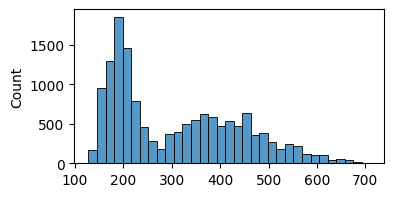

In [41]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [42]:
len(token_lengths)

14760

In [43]:
np.median(token_lengths)

279.0

In [54]:
df_train_ = df_sample.iloc[np.arange(len(token_lengths))[token_lengths<384]]
df_train_.index = range(len(df_train_))

In [55]:
df_train_full_tom = df_train_.loc[df_train_['qprop=non_unique_mental_state']==True].copy()
df_train_full_tom.index = range(len(df_train_full_tom))

df_train_no_tom = df_train_.loc[df_train_['qprop=non_unique_mental_state']==False].copy()
df_train_no_tom.index = range(len(df_train_no_tom))

In [56]:
print(df_train_['sprop=story_accuracy_1st_infilled'].mean(), df_train['sprop=story_accuracy_1st_infilled'].mean())

0.5842032140081593 0.5697793926481955


In [57]:
len(df_train_)

10151

In [59]:
data_train = Dataset.from_pandas(df_train_)
data_train = data_train.map(generate_prompt, with_indices=True)

data_train_full_tom = Dataset.from_pandas(df_train_full_tom)
data_train_full_tom = data_train_full_tom.map(generate_prompt, with_indices=True)

data_train_no_tom = Dataset.from_pandas(df_train_no_tom)
data_train_no_tom = data_train_no_tom.map(generate_prompt, with_indices=True)

Map: 100%|██████████| 5722/5722 [00:00<00:00, 9787.36 examples/s] 


In [60]:
data_train

Dataset({
    features: ['qprop=params', 'param=num_people', 'level_2', 'question', 'answer', 'qprop=nth_order', 'qprop=non_unique_mental_state', 'sprop=is_false_belief_story_1st', 'sprop=is_false_belief_story_1st_and_2nd', 'sprop=story_accuracy_1st_raw', 'sprop=story_accuracy_1st_infilled', 'sprop=global_idx', 'param=story_type', 'param=num_stories_total', 'param=max_sentences', 'param=num_moves', 'param=num_rooms', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story', 'story_type'],
    num_rows: 10151
})

<Axes: ylabel='Count'>

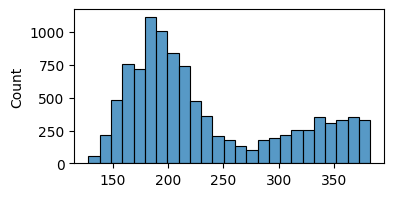

In [61]:
token_lengths = []
for prompt_list in data_train['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [163]:
test_data.to_parquet('cleaned_test_with_structure.parquet')
data_train.to_parquet('cleaned_train_with_structure_384.parquet')

Creating parquet from Arrow format: 100%|██████████| 11/11 [00:00<00:00, 376.64ba/s]


28987871

In [62]:
data_train_full_tom.to_parquet('cleaned_train_ft_with_structure_384.parquet')
data_train_no_tom.to_parquet('cleaned_train_nt_with_structure_384.parquet')

Creating parquet from Arrow format: 100%|██████████| 6/6 [00:00<00:00, 316.37ba/s]


16512034

In [63]:
train_test_ds = load_dataset('parquet', data_files='cleaned_train_ft_with_structure_384.parquet', split='train[:50%]')

Generating train split: 4429 examples [00:00, 356802.64 examples/s]


In [32]:
data_train_full_tom

Dataset({
    features: ['qprop=params', 'param=num_people', 'level_2', 'question', 'answer', 'qprop=nth_order', 'qprop=non_unique_mental_state', 'sprop=is_false_belief_story_1st', 'sprop=is_false_belief_story_1st_and_2nd', 'sprop=story_accuracy_1st_raw', 'sprop=story_accuracy_1st_infilled', 'sprop=global_idx', 'param=story_type', 'param=num_stories_total', 'param=max_sentences', 'param=num_moves', 'param=num_rooms', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story', 'story_type'],
    num_rows: 5723
})

In [165]:
data_train

Dataset({
    features: ['qprop=params', 'param=num_people', 'level_2', 'question', 'answer', 'qprop=nth_order', 'qprop=non_unique_mental_state', 'sprop=is_false_belief_story_1st', 'sprop=is_false_belief_story_1st_and_2nd', 'sprop=story_accuracy_1st_raw', 'sprop=story_accuracy_1st_infilled', 'sprop=global_idx', 'param=story_type', 'param=num_stories_total', 'param=max_sentences', 'param=num_moves', 'param=num_rooms', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story', 'story_type'],
    num_rows: 10145
})

<Axes: ylabel='count'>

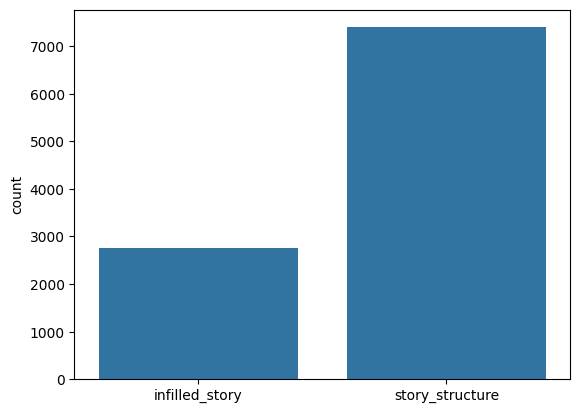

In [166]:
sns.countplot(x=data_train['story_type'])